In [1]:
# Cell 1: Importing required libraries
import os
HOME = os.getcwd()

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from IPython import display
display.clear_output()

import supervision as sv
import numpy as np
from ultralytics import YOLO

# Setting up YOLO model
model = YOLO("yolov8x.pt")
SOURCE_VIDEO_PATH = "yolo_testvids/vid5.mp4"
CLASS_NAMES_DICT = model.model.names

# Selected classes
SELECTED_CLASS_NAMES = ['car']
SELECTED_CLASS_IDS = [
    {value: key for key, value in CLASS_NAMES_DICT.items()}[class_name]
    for class_name in SELECTED_CLASS_NAMES
]
print(f"Selected Class IDs: {SELECTED_CLASS_IDS}")


Selected Class IDs: [2]


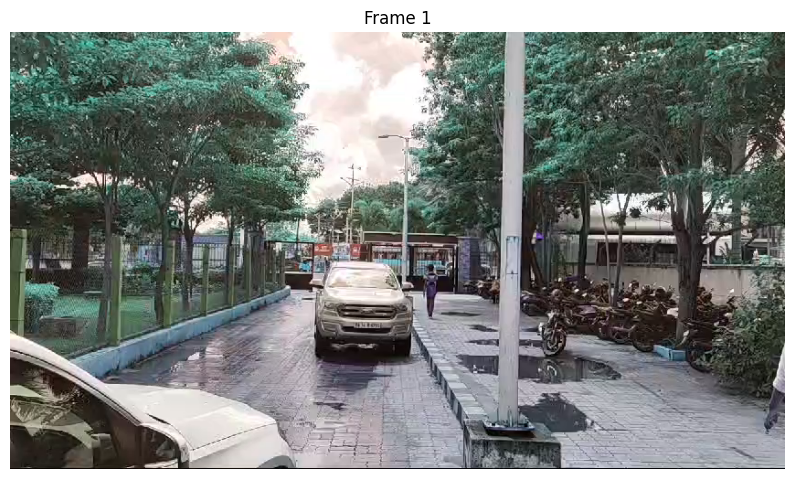

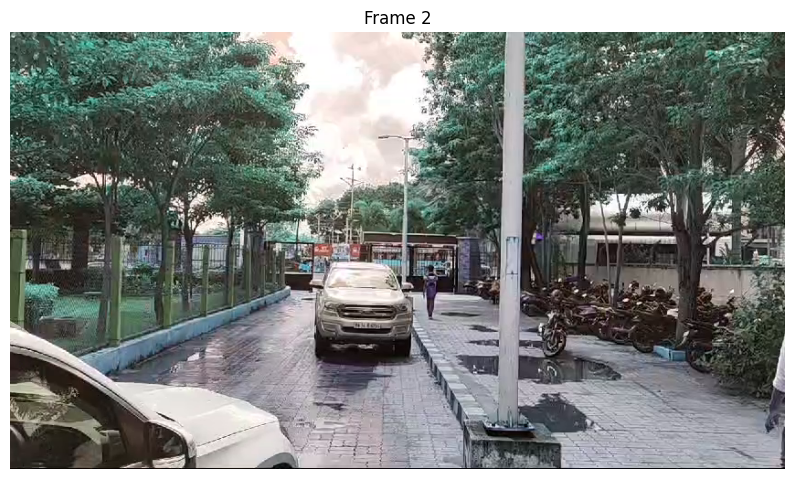

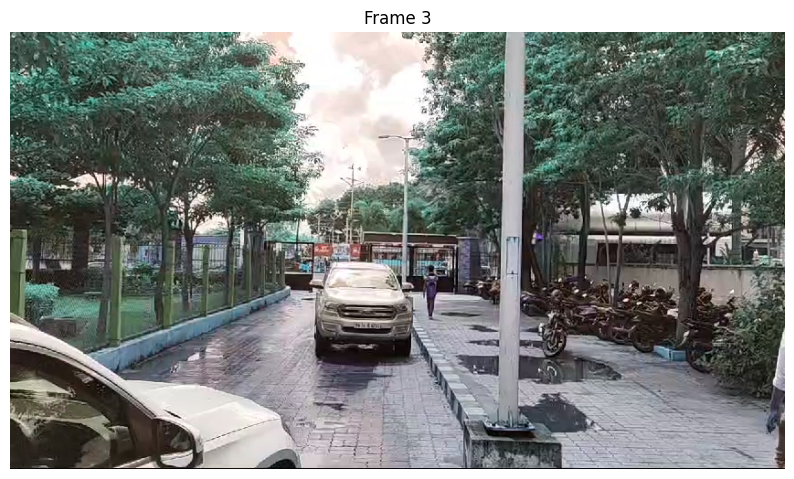

In [ ]:
# Cell 2: Visualize sample frames from the video
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Display a few sample frames
import matplotlib.pyplot as plt

iterator = iter(generator)
for i in range(3):  # Display first 3 frames for a quick visual check
    frame = next(iterator)
    plt.figure(figsize=(10, 10))
    plt.imshow(frame)
    plt.title(f"Frame {i+1}")
    plt.axis('off')
    plt.show()


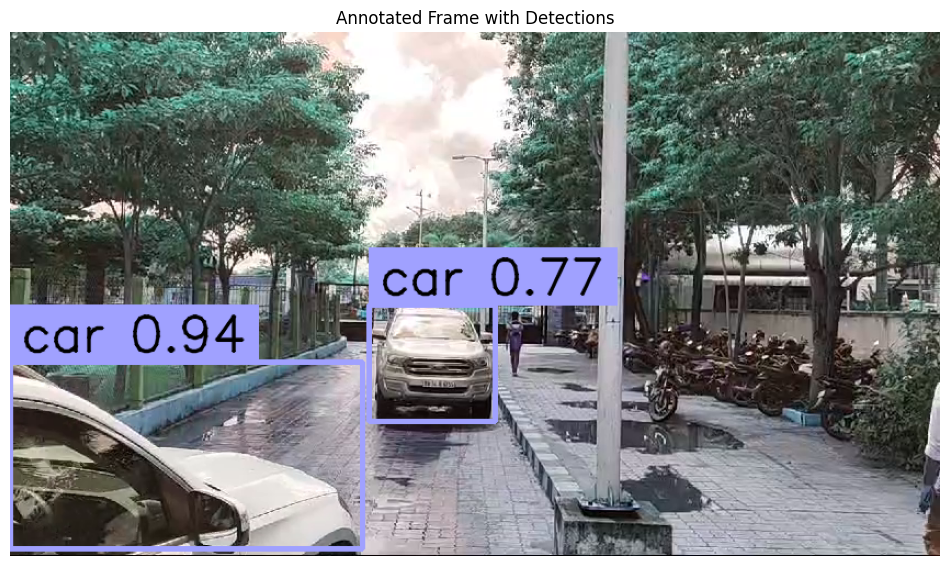

In [4]:
# Cell 3: Model Prediction on a Single Frame with Bounding Box Visualization
# Create annotators
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)

# Get the first frame
iterator = iter(generator)
frame = next(iterator)

# Model prediction  
results = model(frame, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

# Filter detections by selected classes
detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

# Format labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# Annotate and display the frame
annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

# Display annotated frame
plt.figure(figsize=(12, 12))
plt.imshow(annotated_frame)
plt.title("Annotated Frame with Detections")
plt.axis('off')
plt.show()


In [ ]:
# Cell 4: Dynamic Line Zone Configuration
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Define line position as a proportion of video height and width
LINE_START = sv.Point(int(video_info.width * 0.02), int(video_info.height * 0.7))
LINE_END = sv.Point(int(video_info.width * 0.98), int(video_info.height * 0.7))
# LINE_START = sv.Point(0 + 50, 1500)
# LINE_END = sv.Point(3840 - 50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/result.mp4"

print(f"Line Start: {LINE_START}, Line End: {LINE_END}")
print(f"Video Dimensions - Width: {video_info.width}, Height: {video_info.height}")


In [6]:
# Cell 5: Set up Trackers, Counters, and Annotators
in_count, out_count = 0, 0
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3
)
byte_tracker.reset()

# line_zone = sv.LineZone(start=LINE_START, end=LINE_END)
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

print("Trackers, counters, and annotators initialized.")


Trackers, counters, and annotators initialized.


In [ ]:
# Cell 6: Define Callback Function for Video Processing
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    global in_count, out_count
    
    # Model prediction
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

    # Tracking
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    # Annotate frame
    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # Update line zone and counts
    previous_in_count, previous_out_count = line_zone.in_count, line_zone.out_count
    line_zone.trigger(detections)

    if line_zone.in_count > previous_in_count:
        in_count += line_zone.in_count - previous_in_count
    if line_zone.out_count > previous_out_count:
        out_count += line_zone.out_count - previous_out_count

    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

print("Callback function defined.")


In [ ]:
# Cell 7: Process Video and Save Output
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)

print("Video processing completed. Results saved to:", TARGET_VIDEO_PATH)
print(f"Total In Count: {in_count}")
print(f"Total Out Count: {out_count}")


In [ ]:
# Cell 8: Display Processed Video
from IPython.display import Video

# Display video
Video(TARGET_VIDEO_PATH, embed=True, width=800, height=450)


In [ ]:
# Cell 9: Import additional visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# Initialize lists to store counts over time for graphing
in_counts_over_time = []
out_counts_over_time = []
frame_times = []

print("Visualization setup complete.")


In [ ]:
# Cell 10: Modify the callback function to collect data for graphs
def callback_with_timing(frame: np.ndarray, index: int) -> np.ndarray:
    global in_count, out_count, in_counts_over_time, out_counts_over_time, frame_times
    
    # Record time at the start of processing the frame
    start_time = time.time()
    
    # Model prediction and tracking
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    detections = byte_tracker.update_with_detections(detections)

    # Update line zone and counts
    previous_in_count, previous_out_count = line_zone.in_count, line_zone.out_count
    line_zone.trigger(detections)
    
    # Update in and out counts if they change
    if line_zone.in_count > previous_in_count:
        in_count += line_zone.in_count - previous_in_count
    if line_zone.out_count > previous_out_count:
        out_count += line_zone.out_count - previous_out_count

    # Append counts and frame processing time to lists
    in_counts_over_time.append(in_count)
    out_counts_over_time.append(out_count)
    frame_times.append(time.time() - start_time)

    # Annotate frame as before
    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

print("Modified callback function for data collection defined.")


In [ ]:
# Cell 11: Process Video with Data Collection for Graphs
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback_with_timing
)

print("Video processed with data collection. Results saved to:", TARGET_VIDEO_PATH)
print(f"Final In Count: {in_count}")
print(f"Final Out Count: {out_count}")


In [ ]:
# Cell 12: Plot In and Out Counts Over Time
plt.figure(figsize=(12, 6))
plt.plot(in_counts_over_time, label='In Count', color='green')
plt.plot(out_counts_over_time, label='Out Count', color='red')
plt.xlabel("Frame Index")
plt.ylabel("Cumulative Count")
plt.title("Cumulative In and Out Counts Over Time")
plt.legend()
plt.show()


In [ ]:
# Cell 13: Plot Frame Processing Time
plt.figure(figsize=(12, 6))
plt.plot(frame_times, label="Frame Processing Time (s)", color='blue')
plt.xlabel("Frame Index")
plt.ylabel("Processing Time (seconds)")
plt.title("Frame Processing Time Over Video Duration")
plt.legend()
plt.show()


In [ ]:
# Cell 14: Distribution of Frame Processing Times
sns.histplot(frame_times, kde=True, color='purple')
plt.xlabel("Processing Time (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Frame Processing Times")
plt.show()


In [ ]:
import os
HOME = os.getcwd()

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from IPython import display
display.clear_output()

import supervision as sv
from supervision.assets import download_assets, VideoAssets

from ultralytics import YOLO

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load YOLO model
model = YOLO("yolov8x.pt")

# Define paths and class names
SOURCE_VIDEO_PATH = "vehicles.mp4"
CLASS_NAMES_DICT = model.model.names
SELECTED_CLASS_NAMES = ['car', 'bus', 'truck']
SELECTED_CLASS_IDS = [
    {value: key for key, value in CLASS_NAMES_DICT.items()}[class_name]
    for class_name in SELECTED_CLASS_NAMES
]

# Load video frames generator and create annotators
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)

# Define line for counting
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840 - 50, 1500)
TARGET_VIDEO_PATH = f"{HOME}/result.mp4"
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Global counters and trackers
in_count = 0
out_count = 0
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3
)
byte_tracker.reset()

# Create LineZone instance
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# Additional lists for metrics visualization
iou_values = []
in_count_list = []
out_count_list = []
true_positives = defaultdict(int)
false_positives = defaultdict(int)
false_negatives = defaultdict(int)

# Annotators
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Calculate IoU for detections
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2
    inter_x1 = max(x1, x1_p)
    inter_y1 = max(y1, y1_p)
    inter_x2 = min(x2, x2_p)
    inter_y2 = min(y2, y2_p)
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

# Callback function for processing each frame
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    global in_count, out_count, iou_values

    # Model prediction on frame
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

    # Track detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    # Annotate frame
    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # Update line zone and increment counters
    previous_in_count, previous_out_count = line_zone.in_count, line_zone.out_count
    line_zone.trigger(detections)

    if line_zone.in_count > previous_in_count:
        in_count += line_zone.in_count - previous_in_count
        print("in:", in_count)
    if line_zone.out_count > previous_out_count:
        out_count += line_zone.out_count - previous_out_count
        print("out:", out_count)

    # Append cumulative counts
    in_count_list.append(in_count)
    out_count_list.append(out_count)

    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# Process video and save result
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)

print(f"Total In Count: {in_count}")
print(f"Total Out Count: {out_count}")

# Visualization functions for metrics
def plot_precision_recall_curve():
    precisions, recalls = [], []
    for class_id in SELECTED_CLASS_IDS:
        tp = true_positives[class_id]
        fp = false_positives[class_id]
        fn = false_negatives[class_id]
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        precisions.append(precision)
        recalls.append(recall)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.show()

def plot_f1_scores():
    f1_scores = []
    class_labels = []
    for class_id in SELECTED_CLASS_IDS:
        tp = true_positives[class_id]
        fp = false_positives[class_id]
        fn = false_negatives[class_id]
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
        f1_scores.append(f1)
        class_labels.append(CLASS_NAMES_DICT[class_id])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_labels, y=f1_scores, palette="viridis")
    plt.xlabel('Classes')
    plt.ylabel('F1-Score')
    plt.title('F1-Score by Class')
    plt.show()

def plot_iou_distribution():
    plt.figure(figsize=(10, 6))
    sns.histplot(iou_values, bins=20, kde=True)
    plt.xlabel('IoU')
    plt.ylabel('Frequency')
    plt.title('IoU Distribution')
    plt.grid(True)
    plt.show()

def plot_cumulative_counts():
    plt.figure(figsize=(12, 6))
    plt.plot(in_count_list, label='In Count', color='blue')
    plt.plot(out_count_list, label='Out Count', color='orange')
    plt.xlabel('Frame Index')
    plt.ylabel('Cumulative Count')
    plt.title('Cumulative In and Out Counts Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot all metrics after video processing
plot_precision_recall_curve()
plot_f1_scores()
plot_iou_distribution()
plot_cumulative_counts()


In [ ]:
import supervision as sv
import numpy as np
import cv2
from dataclasses import dataclass
from typing import Dict, Tuple

@dataclass
class VehicleTracker:
    """Tracks vehicle movement based on distance from camera."""
    disappearing_threshold: float = 0.8  # How much the area needs to change to count as in/out
    min_frames_tracked: int = 5  # Minimum frames to track before counting
    area_smoothing: int = 3  # Number of frames to average area over
    
    def __init__(self):
        self.vehicle_history: Dict[int, list] = {}  # tracker_id -> list of areas
        self.counted_vehicles: set = set()  # tracker_ids that have been counted
        self.in_count: int = 0
        self.out_count: int = 0
    
    def calculate_box_area(self, box: np.ndarray) -> float:
        """Calculate area of bounding box."""
        width = box[2] - box[0]
        height = box[3] - box[1]
        return width * height
    
    def get_movement_direction(self, areas: list) -> Tuple[str, float]:
        """
        Determine if vehicle is moving towards or away from camera.
        Returns direction ('in', 'out', or None) and change ratio.
        """
        if len(areas) < self.min_frames_tracked:
            return None, 0
            
        # Use moving average to smooth area measurements
        smoothed_areas = []
        for i in range(len(areas) - self.area_smoothing + 1):
            avg = np.mean(areas[i:i + self.area_smoothing])
            smoothed_areas.append(avg)
            
        if len(smoothed_areas) < 2:
            return None, 0
            
        # Calculate ratio of change
        start_area = smoothed_areas[0]
        end_area = smoothed_areas[-1]
        change_ratio = (end_area - start_area) / start_area
        
        # Determine direction based on area change
        if abs(change_ratio) > self.disappearing_threshold:
            if change_ratio > 0:
                return 'in', change_ratio
            else:
                return 'out', change_ratio
                
        return None, change_ratio

    def update(self, detections: sv.Detections) -> Tuple[list, list]:
        """
        Update vehicle tracking and count vehicles moving in/out.
        Returns lists of in/out vehicle IDs for current frame.
        """
        current_in_vehicles = []
        current_out_vehicles = []
        
        # Update history for each detection
        for idx, (tracker_id, box) in enumerate(zip(detections.tracker_id, detections.xyxy)):
            area = self.calculate_box_area(box)
            
            if tracker_id not in self.vehicle_history:
                self.vehicle_history[tracker_id] = []
            self.vehicle_history[tracker_id].append(area)
            
            # Only process if not already counted
            if tracker_id not in self.counted_vehicles:
                direction, change_ratio = self.get_movement_direction(self.vehicle_history[tracker_id])
                
                if direction == 'in':
                    self.in_count += 1
                    self.counted_vehicles.add(tracker_id)
                    current_in_vehicles.append(tracker_id)
                elif direction == 'out':
                    self.out_count += 1
                    self.counted_vehicles.add(tracker_id)
                    current_out_vehicles.append(tracker_id)
        
        # Clean up old tracks
        current_ids = set(detections.tracker_id)
        self.vehicle_history = {k: v for k, v in self.vehicle_history.items() 
                              if k in current_ids}
        
        return current_in_vehicles, current_out_vehicles

# Modified callback function for video processing
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Model prediction and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    
    # Filter for selected classes
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    
    # Track detections
    detections = byte_tracker.update_with_detections(detections)
    
    # Update vehicle tracking
    current_in_vehicles, current_out_vehicles = vehicle_tracker.update(detections)
    
    # Create labels with movement indication
    labels = []
    for confidence, class_id, tracker_id in zip(
        detections.confidence, detections.class_id, detections.tracker_id):
        movement = ""
        if tracker_id in current_in_vehicles:
            movement = "→ IN"
        elif tracker_id in current_out_vehicles:
            movement = "← OUT"
        
        labels.append(
            f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f} {movement}"
        )
    
    # Annotate frame
    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels
    )
    
    # Add count overlay
    counts_text = f"IN: {vehicle_tracker.in_count} OUT: {vehicle_tracker.out_count}"
    cv2.putText(
        annotated_frame, counts_text,
        (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3
    )
    
    return annotated_frame

# Initialize tracker and process video
vehicle_tracker = VehicleTracker()
byte_tracker = sv.ByteTrack()

sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)

In [ ]:
import supervision as sv
import numpy as np
from dataclasses import dataclass
from typing import Dict, Tuple, List
from collections import defaultdict

@dataclass
class VehicleTrajectory:
    """Stores complete trajectory information for a vehicle"""
    id: int
    areas: List[float]
    first_seen: int
    last_seen: int
    counted: bool = False
    direction: str = None

class CompleteTrajectoriesTracker:
    """Tracks complete vehicle trajectories and determines direction based on full path"""
    def __init__(
        self,
        min_trajectory_length: int = 10,
        area_change_threshold: float = 0.4,
        smoothing_window: int = 5
    ):
        self.trajectories: Dict[int, VehicleTrajectory] = {}
        self.completed_trajectories: Dict[int, VehicleTrajectory] = {}
        self.min_trajectory_length = min_trajectory_length
        self.area_change_threshold = area_change_threshold
        self.smoothing_window = smoothing_window
        self.frame_count = 0
        self.in_count = 0
        self.out_count = 0
        
    def calculate_box_area(self, box: np.ndarray) -> float:
        """Calculate area of bounding box"""
        width = box[2] - box[0]
        height = box[3] - box[1]
        return width * height
    
    def smooth_areas(self, areas: List[float]) -> List[float]:
        """Apply moving average smoothing to area measurements"""
        if len(areas) < self.smoothing_window:
            return areas
        
        smoothed = []
        for i in range(len(areas) - self.smoothing_window + 1):
            window = areas[i:i + self.smoothing_window]
            smoothed.append(np.mean(window))
        return smoothed
    
    def analyze_trajectory(self, trajectory: VehicleTrajectory) -> str:
        """
        Analyze complete trajectory to determine movement direction.
        Returns 'in', 'out', or None if direction is unclear.
        """
        if len(trajectory.areas) < self.min_trajectory_length:
            return None
            
        # Smooth the area measurements
        smoothed_areas = self.smooth_areas(trajectory.areas)
        if len(smoothed_areas) < 2:
            return None
            
        # Find peaks and troughs in the smoothed data
        peaks = []
        troughs = []
        for i in range(1, len(smoothed_areas) - 1):
            if smoothed_areas[i] > smoothed_areas[i-1] and smoothed_areas[i] > smoothed_areas[i+1]:
                peaks.append((i, smoothed_areas[i]))
            if smoothed_areas[i] < smoothed_areas[i-1] and smoothed_areas[i] < smoothed_areas[i+1]:
                troughs.append((i, smoothed_areas[i]))
        
        # Calculate overall trend
        start_area = np.mean(smoothed_areas[:3])  # Average first few points
        end_area = np.mean(smoothed_areas[-3:])   # Average last few points
        total_change = (end_area - start_area) / start_area
        
        # Analyze the pattern
        if abs(total_change) > self.area_change_threshold:
            if len(peaks) > 0 and len(troughs) > 0:
                # If we have both peaks and troughs, use their sequence
                max_peak = max(peaks, key=lambda x: x[1])
                min_trough = min(troughs, key=lambda x: x[1])
                
                if max_peak[0] < min_trough[0]:  # Peak before trough
                    return 'out'
                else:  # Trough before peak
                    return 'in'
            else:
                # If no clear peaks/troughs, use overall trend
                if total_change > 0:
                    return 'in'
                else:
                    return 'out'
                    
        return None
    
    def update(self, detections: sv.Detections) -> Tuple[List[int], List[int]]:
        """
        Update trajectories with new detections and determine vehicle directions
        Returns lists of IDs that were counted as in/out in this frame
        """
        self.frame_count += 1
        current_in_ids = []
        current_out_ids = []
        current_ids = set(detections.tracker_id)
        
        # Update existing trajectories and add new ones
        for idx, (tracker_id, box) in enumerate(zip(detections.tracker_id, detections.xyxy)):
            area = self.calculate_box_area(box)
            
            if tracker_id not in self.trajectories:
                self.trajectories[tracker_id] = VehicleTrajectory(
                    id=tracker_id,
                    areas=[area],
                    first_seen=self.frame_count,
                    last_seen=self.frame_count
                )
            else:
                self.trajectories[tracker_id].areas.append(area)
                self.trajectories[tracker_id].last_seen = self.frame_count
        
        # Move disappeared trajectories to completed_trajectories and analyze them
        disappeared_ids = set(self.trajectories.keys()) - current_ids
        for track_id in disappeared_ids:
            trajectory = self.trajectories[track_id]
            
            if not trajectory.counted:  # Only process if not already counted
                direction = self.analyze_trajectory(trajectory)
                if direction == 'in':
                    self.in_count += 1
                    current_in_ids.append(track_id)
                    trajectory.direction = 'in'
                    trajectory.counted = True
                elif direction == 'out':
                    self.out_count += 1
                    current_out_ids.append(track_id)
                    trajectory.direction = 'out'
                    trajectory.counted = True
                    
            self.completed_trajectories[track_id] = trajectory
            del self.trajectories[track_id]
        
        return current_in_ids, current_out_ids

    def get_counts(self) -> Tuple[int, int]:
        """Return the current in and out counts"""
        return self.in_count, self.out_count

# Initialize trackers
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3
)
trajectory_tracker = CompleteTrajectoriesTracker()

def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Model prediction and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    
    # Filter for selected classes
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    
    # Track detections
    detections = byte_tracker.update_with_detections(detections)
    
    # Update trajectory tracking
    current_in_ids, current_out_ids = trajectory_tracker.update(detections)
    
    # Create labels with movement indication and trajectory info
    labels = []
    for confidence, class_id, tracker_id in zip(
        detections.confidence, detections.class_id, detections.tracker_id):
        
        movement = ""
        if tracker_id in current_in_ids:
            movement = "→ IN"
        elif tracker_id in current_out_ids:
            movement = "← OUT"
        
        # Add trajectory information
        if tracker_id in trajectory_tracker.trajectories:
            traj = trajectory_tracker.trajectories[tracker_id]
            area_change = ""
            if len(traj.areas) > 1:
                change = (traj.areas[-1] - traj.areas[0]) / traj.areas[0]
                area_change = f" Δ:{change:.2f}"
        
        labels.append(
            f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}{movement}{area_change}"
        )
    
    # Annotate frame
    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels
    )
    
    # Add count overlay
    in_count, out_count = trajectory_tracker.get_counts()
    counts_text = f"IN: {in_count} OUT: {out_count}"
    cv2.putText(
        annotated_frame, counts_text,
        (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3
    )
    
    return annotated_frame

# Process the video
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)

# Get final counts
final_in, final_out = trajectory_tracker.get_counts()
print(f"Final counts - IN: {final_in}, OUT: {final_out}")

In [9]:
import supervision as sv
import numpy as np
from dataclasses import dataclass
from typing import Dict, Tuple, List
import cv2

@dataclass
class VehicleTrajectory:
    """Stores complete trajectory information for a vehicle"""
    id: int
    positions: List[Tuple[float, float]]  # Center positions (x, y)
    areas: List[float]
    first_seen: int
    last_seen: int
    counted: bool = False
    direction: str = None

class SideViewTracker:
    """Specialized tracker for side-view camera setup"""
    def __init__(
        self,
        min_trajectory_length: int = 8,        # Reduced due to side view
        area_change_threshold: float = 0.3,    # Adjusted for side perspective
        smoothing_window: int = 3,             # Reduced for more responsive tracking
        position_change_weight: float = 0.7,   # Weight for position vs size change
        min_horizontal_movement: float = 50    # Minimum pixels of horizontal movement
    ):
        self.trajectories: Dict[int, VehicleTrajectory] = {}
        self.completed_trajectories: Dict[int, VehicleTrajectory] = {}
        self.min_trajectory_length = min_trajectory_length
        self.area_change_threshold = area_change_threshold
        self.smoothing_window = smoothing_window
        self.position_change_weight = position_change_weight
        self.min_horizontal_movement = min_horizontal_movement
        self.frame_count = 0
        self.in_count = 0
        self.out_count = 0
    
    def get_box_center_and_area(self, box: np.ndarray) -> Tuple[Tuple[float, float], float]:
        """Calculate box center position and area"""
        x1, y1, x2, y2 = box
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        area = (x2 - x1) * (y2 - y1)
        return (center_x, center_y), area

    def analyze_trajectory(self, trajectory: VehicleTrajectory) -> str:
        """Analyze trajectory considering both position and size changes"""
        if len(trajectory.positions) < self.min_trajectory_length:
            return None

        # Analyze horizontal movement
        start_x = trajectory.positions[0][0]
        end_x = trajectory.positions[-1][0]
        horizontal_movement = end_x - start_x

        # Only count if there's significant horizontal movement
        if abs(horizontal_movement) < self.min_horizontal_movement:
            return None

        # Calculate size change
        size_change = (trajectory.areas[-1] - trajectory.areas[0]) / trajectory.areas[0]

        # Combine position and size information for decision
        if horizontal_movement > 0:  # Moving right in frame
            return 'in' if size_change > -self.area_change_threshold else 'out'
        else:  # Moving left in frame
            return 'out' if size_change > -self.area_change_threshold else 'in'

    def update(self, detections: sv.Detections) -> Tuple[List[int], List[int]]:
        """Update trajectories and count vehicles"""
        self.frame_count += 1
        current_in_ids = []
        current_out_ids = []
        current_ids = set(detections.tracker_id)

        # Update existing trajectories and add new ones
        for idx, (tracker_id, box) in enumerate(zip(detections.tracker_id, detections.xyxy)):
            center, area = self.get_box_center_and_area(box)
            
            if tracker_id not in self.trajectories:
                self.trajectories[tracker_id] = VehicleTrajectory(
                    id=tracker_id,
                    positions=[center],
                    areas=[area],
                    first_seen=self.frame_count,
                    last_seen=self.frame_count
                )
            else:
                self.trajectories[tracker_id].positions.append(center)
                self.trajectories[tracker_id].areas.append(area)
                self.trajectories[tracker_id].last_seen = self.frame_count

        # Process disappeared vehicles
        disappeared_ids = set(self.trajectories.keys()) - current_ids
        for track_id in disappeared_ids:
            trajectory = self.trajectories[track_id]
            
            if not trajectory.counted:
                direction = self.analyze_trajectory(trajectory)
                if direction == 'in':
                    self.in_count += 1
                    current_in_ids.append(track_id)
                    trajectory.direction = 'in'
                    trajectory.counted = True
                elif direction == 'out':
                    self.out_count += 1
                    current_out_ids.append(track_id)
                    trajectory.direction = 'out'
                    trajectory.counted = True
                    
            self.completed_trajectories[track_id] = trajectory
            del self.trajectories[track_id]

        return current_in_ids, current_out_ids

    def get_counts(self) -> Tuple[int, int]:
        """Return the current in and out counts"""
        return self.in_count, self.out_count

def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Model prediction and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    
    # Filter for selected classes
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    
    # Track detections
    detections = byte_tracker.update_with_detections(detections)
    
    # Update trajectory tracking
    current_in_ids, current_out_ids = trajectory_tracker.update(detections)
    
    # Create labels with movement indication
    labels = []
    for confidence, class_id, tracker_id in zip(
        detections.confidence, detections.class_id, detections.tracker_id):
        
        movement = ""
        if tracker_id in current_in_ids:
            movement = "→ IN"
        elif tracker_id in current_out_ids:
            movement = "← OUT"
        
        labels.append(
            f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f} {movement}"
        )
    
    # Annotate frame
    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels
    )
    
    # Add count overlay
    in_count, out_count = trajectory_tracker.get_counts()
    counts_text = f"IN: {in_count} OUT: {out_count}"
    cv2.putText(
        annotated_frame, counts_text,
        (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3
    )
    
    return annotated_frame

# Initialize trackers
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3
)
trajectory_tracker = SideViewTracker()

# Process video
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path="result_final.mp4",
    callback=callback
)

# Print final counts
final_in, final_out = trajectory_tracker.get_counts()
print(f"Final counts - IN: {final_in}, OUT: {final_out}")

Final counts - IN: 1, OUT: 2


In [ ]:
import supervision as sv
import numpy as np
from dataclasses import dataclass
from typing import Dict, Tuple, List
import cv2

@dataclass
class VehicleTrajectory:
    """Stores complete trajectory information for a vehicle"""
    id: int
    positions: List[Tuple[float, float]]  # Center positions (x, y)
    areas: List[float]
    first_seen: int
    last_seen: int
    counted: bool = False
    direction: str = None
    avg_size_change: float = 0.0

class CompleteVideoTracker:
    """Analyzes all vehicles over complete video duration"""
    def __init__(
        self,
        min_trajectory_length: int = 8,
        size_change_threshold: float = 0.15,  # Threshold for significant size change
        min_horizontal_movement: float = 50
    ):
        self.trajectories: Dict[int, VehicleTrajectory] = {}
        self.min_trajectory_length = min_trajectory_length
        self.size_change_threshold = size_change_threshold
        self.min_horizontal_movement = min_horizontal_movement
        self.frame_count = 0
        self.final_analysis_done = False
        self.in_count = 0
        self.out_count = 0
        self.analyzed_ids = set()
    
    def get_box_center_and_area(self, box: np.ndarray) -> Tuple[Tuple[float, float], float]:
        """Calculate box center position and area"""
        x1, y1, x2, y2 = box
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        area = (x2 - x1) * (y2 - y1)
        return (center_x, center_y), area

    def calculate_average_size_change(self, areas: List[float]) -> float:
        """Calculate average rate of size change over trajectory"""
        if len(areas) < 2:
            return 0.0
        
        # Calculate percentage changes between consecutive frames
        changes = [(areas[i] - areas[i-1]) / areas[i-1] for i in range(1, len(areas))]
        return np.mean(changes)

    def analyze_trajectory(self, trajectory: VehicleTrajectory) -> str:
        """Analyze complete trajectory for direction determination"""
        if len(trajectory.positions) < self.min_trajectory_length:
            return None

        # Calculate horizontal movement
        start_x = trajectory.positions[0][0]
        end_x = trajectory.positions[-1][0]
        total_horizontal_movement = end_x - start_x

        # Skip if insufficient movement
        if abs(total_horizontal_movement) < self.min_horizontal_movement:
            return None

        # Calculate average size change rate
        avg_size_change = self.calculate_average_size_change(trajectory.areas)
        trajectory.avg_size_change = avg_size_change

        # Determine direction based on size change trend
        if abs(avg_size_change) > self.size_change_threshold:
            if avg_size_change > 0:
                return 'in'
            else:
                return 'out'
        
        return None

    def update(self, detections: sv.Detections) -> Tuple[List[int], List[int]]:
        """Update trajectories with new detections"""
        self.frame_count += 1
        current_in_ids = []
        current_out_ids = []

        # Update existing trajectories and add new ones
        for idx, (tracker_id, box) in enumerate(zip(detections.tracker_id, detections.xyxy)):
            center, area = self.get_box_center_and_area(box)
            
            if tracker_id not in self.trajectories:
                self.trajectories[tracker_id] = VehicleTrajectory(
                    id=tracker_id,
                    positions=[center],
                    areas=[area],
                    first_seen=self.frame_count,
                    last_seen=self.frame_count
                )
            else:
                self.trajectories[tracker_id].positions.append(center)
                self.trajectories[tracker_id].areas.append(area)
                self.trajectories[tracker_id].last_seen = self.frame_count

            # Analyze trajectory if not already counted
            if tracker_id not in self.analyzed_ids:
                direction = self.analyze_trajectory(self.trajectories[tracker_id])
                if direction:
                    self.trajectories[tracker_id].direction = direction
                    self.analyzed_ids.add(tracker_id)
                    if direction == 'in':
                        current_in_ids.append(tracker_id)
                    else:
                        current_out_ids.append(tracker_id)

        return current_in_ids, current_out_ids

    def finalize_analysis(self) -> Tuple[int, int]:
        """Perform final analysis of all trajectories at video end"""
        if self.final_analysis_done:
            return self.in_count, self.out_count

        in_count = 0
        out_count = 0
        
        # Analyze all trajectories
        for track_id, trajectory in self.trajectories.items():
            if track_id not in self.analyzed_ids:
                direction = self.analyze_trajectory(trajectory)
                if direction == 'in':
                    in_count += 1
                elif direction == 'out':
                    out_count += 1

        self.in_count = in_count
        self.out_count = out_count
        self.final_analysis_done = True
        
        return in_count, out_count

    def get_current_counts(self) -> Tuple[int, int]:
        """Get current counts from analyzed trajectories"""
        in_count = sum(1 for tid in self.analyzed_ids 
                      if self.trajectories[tid].direction == 'in')
        out_count = sum(1 for tid in self.analyzed_ids 
                       if self.trajectories[tid].direction == 'out')
        return in_count, out_count

def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Model prediction and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    
    # Filter for selected classes
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    
    # Track detections
    detections = byte_tracker.update_with_detections(detections)
    
    # Update trajectory tracking
    current_in_ids, current_out_ids = trajectory_tracker.update(detections)
    
    # Create labels with movement and size change information
    labels = []
    for confidence, class_id, tracker_id in zip(
        detections.confidence, detections.class_id, detections.tracker_id):
        
        movement = ""
        size_info = ""
        if tracker_id in trajectory_tracker.trajectories:
            traj = trajectory_tracker.trajectories[tracker_id]
            if hasattr(traj, 'avg_size_change'):
                size_info = f" Δ:{traj.avg_size_change:.2f}"
            
            if traj.direction == 'in':
                movement = "→ IN"
            elif traj.direction == 'out':
                movement = "← OUT"
        
        labels.append(
            f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}{movement}{size_info}"
        )
    
    # Annotate frame
    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels
    )
    
    # Add count overlay
    in_count, out_count = trajectory_tracker.get_current_counts()
    counts_text = f"IN: {in_count} OUT: {out_count}"
    cv2.putText(
        annotated_frame, counts_text,
        (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3
    )
    
    return annotated_frame

# Initialize trackers
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3
)
trajectory_tracker = CompleteVideoTracker()

# Process video
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)

# Perform final analysis and get counts
final_in, final_out = trajectory_tracker.finalize_analysis()
print(f"Final counts - IN: {final_in}, OUT: {final_out}")

# Print detailed statistics
print("\nDetailed Vehicle Statistics:")
for track_id, trajectory in trajectory_tracker.trajectories.items():
    if trajectory.direction:
        print(f"Vehicle #{track_id}:")
        print(f"  Direction: {trajectory.direction}")
        print(f"  Average size change: {trajectory.avg_size_change:.3f}")
        print(f"  Frames tracked: {len(trajectory.areas)}")